In [40]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.preprocessing import FunctionTransformer


from sklearn import set_config
set_config(transform_output="pandas")

# Set random seed 
RSEED = 42

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings("ignore")

In [2]:
# load the dataset
df = pd.read_csv("./df_diabetes.csv", encoding="utf-8")
df.head()


,pregnancies,Age,bmi,pedigree_f,outcome,skinthickness,insulin,glucose,bloodpressure
0,6,50,33.6,1,1,35,0,148,72
1,1,31,26.6,0,0,29,0,85,66
2,8,32,23.3,1,1,0,0,183,64
3,1,21,28.1,0,0,23,94,89,66
4,0,33,43.1,2,1,35,168,137,40


# Modelling:

In [41]:
# Defining X and y

X = df.drop('outcome', axis=1)
y = df['outcome']

# Splitting the dataset, stratify on target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=df.outcome)

# Check the shape of the data sets
print("X_train:", X_train.shape)  
print("y_train:", y_train.shape)   
print("X_test:", X_test.shape)  
print("y_test:", y_test.shape)     

X_train: (537, 8)
y_train: (537,)
X_test: (231, 8)
y_test: (231,)


## Preprocessing Pipeline
No categorical column found. No need categorical pipeline. Also, no null values found and there is no need for imputation

In [42]:


num_pipeline = Pipeline([
    ('num_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num_processor', num_pipeline, ['Age','bmi','skinthickness','insulin','glucose','bloodpressure'])
])

preprocessor

ColumnTransformer(transformers=[('num_processor',
                                 Pipeline(steps=[('num_scaler',
                                                  StandardScaler())]),
                                 ['Age', 'bmi', 'skinthickness', 'insulin',
                                  'glucose', 'bloodpressure'])])

In [43]:
preprocessor.fit_transform(X_train)

,num_processor__Age,num_processor__bmi,num_processor__skinthickness,num_processor__insulin,num_processor__glucose,num_processor__bloodpressure
209,0.632129,0.431483,0.812564,-0.722392,2.017945,0.780670
176,0.716992,-0.119832,-1.316902,-0.722392,-1.148619,0.465388
147,0.038086,-0.209581,0.941623,0.373154,-0.476923,-0.270269
454,-0.810548,0.726372,0.489918,0.244266,-0.668836,-0.795739
636,1.226172,-0.427543,-1.316902,-0.722392,-0.540894,0.255200
...,...,...,...,...,...,...
214,0.207812,0.264806,0.748035,0.888705,-0.285010,0.675576
113,-0.725684,0.239163,-1.316902,-0.722392,-1.436488,-0.375363
556,-0.301368,0.764836,1.264269,-0.722392,-0.764793,0.045012
759,2.753712,0.431483,-1.316902,-0.722392,2.209858,1.201045


## Training different models using a model pipeline

In [44]:
# define preprocessor variables (with or without scaling)
preprocessor_with_scaler = Pipeline([
    ('num_scaler', StandardScaler()),
])
preprocessor_without_scaler = Pipeline([
    ('identity_transform', FunctionTransformer(func=lambda x: x))
])

# build model pipeline, insert further models
pipelines = {
    'LogisticRegression': Pipeline([
        ('preprocessor', preprocessor_with_scaler),
        ('model', LogisticRegression())
    ]),
    'DecisionTreeClassifier': Pipeline([
        ('preprocessor', preprocessor_without_scaler),
        ('model', DecisionTreeClassifier())
    ]),
    'KNearestNeighbor': Pipeline([
        ('preprocessor', preprocessor_without_scaler),
        ('model', KNeighborsClassifier())
    ]),
    'RandomForestClassifier': Pipeline([
        ('preprocessor', preprocessor_without_scaler),
        ('model', RandomForestClassifier())
    ])
}

## Improving the models using Gridsearch:

In [49]:
# create parameters for each model
logreg_parameter_grid = {
    'model__penalty': ['l1', 'l2', 'none'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'model__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'model__class_weight': [None, 'balanced']
}

dectree_parameter_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'model__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'model__max_features': [None, 'auto', 'sqrt', 'log2'],
    'model__class_weight': [None, 'balanced']
}

knn_parameter_grid = {
    'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'model__weights': [None, 'uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': [30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'model__p': [1, 2],
    'model__metric': ['minkowski', 'euclidean', 'manhattan']
}

rf_parameter_grid = {
    'model__n_estimators': [100, 300, 500, 700, 1000],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 4, 5, 6, 7],
    'model__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'model__min_samples_leaf': [1, 2, 3, 4, 6, 8, 10, 12],
}

In [51]:
# Define parameter grids
param_grids = {
    'LogisticRegression': logreg_parameter_grid,
    'DecisionTreeClassifier': dectree_parameter_grid,
    'KNearestNeighbor': knn_parameter_grid,
    'RandomForestClassifier': rf_parameter_grid 
    }

# function for training and fit of the model

def model_train_and_fit(pipeline, param_grid, X_train, y_train):
    grid_search = RandomizedSearchCV(pipeline, param_grid,  n_iter=200, cv=5, n_jobs=-1, scoring='recall')
    grid_search.fit(X_train, y_train)
    return grid_search

# apply training and fit function part 1
logreg_grid_search = model_train_and_fit(pipelines['LogisticRegression'], param_grids['LogisticRegression'], X_train, y_train)
dectree_grid_search = model_train_and_fit(pipelines['DecisionTreeClassifier'], param_grids['DecisionTreeClassifier'], X_train, y_train)
knn_grid_search = model_train_and_fit(pipelines['KNearestNeighbor'], param_grids['KNearestNeighbor'], X_train, y_train) 
rf_grid_search = model_train_and_fit(pipelines['RandomForestClassifier'], param_grids['RandomForestClassifier'], X_train, y_train)



## Evaluate Results

In [55]:
# Function to evaluate a model and print results
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    
    print(model_name)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Recall: {:.2f}".format(recall))
    print("Precision: {:.2f}".format(precision))
    print()

# Print best scores and parameters
print('Best score log regression:\n{:.2f}'.format(logreg_grid_search.best_score_))
print("Best parameters log regression:\n{}".format(logreg_grid_search.best_params_))
print('Best score decision tree:\n{:.2f}'.format(dectree_grid_search.best_score_))
print("Best parameters decision tree:\n{}".format(dectree_grid_search.best_params_))
print('Best score k_nearest_neighbor:\n{:.2f}'.format(knn_grid_search.best_score_))
print("Best parameters k_nearest_neighbor:\n{}".format(knn_grid_search.best_params_))
print('Best score random forest:\n{:.2f}'.format(rf_grid_search.best_score_))
print("Best parameters random forest:\n{}".format(rf_grid_search.best_params_))


# Get best models
best_model_logreg = logreg_grid_search.best_estimator_
best_model_decision_tree = dectree_grid_search.best_estimator_
best_model_knn = knn_grid_search.best_estimator_
best_model_rf = rf_grid_search.best_estimator_

# Evaluate models and print results
evaluate_model(best_model_logreg, X_test, y_test, "Logistic Regression")
evaluate_model(best_model_decision_tree, X_test, y_test, "Decision Tree")
evaluate_model(best_model_knn, X_test, y_test, "K-Nearest Neighbors")
evaluate_model(best_model_rf, X_test, y_test, "Random Forest")


Best score log regression:
0.75
Best parameters log regression:
{'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__max_iter': 900, 'model__class_weight': 'balanced', 'model__C': 0.1}
Best score decision tree:
0.79
Best parameters decision tree:
{'model__min_samples_split': 5, 'model__min_samples_leaf': 8, 'model__max_features': None, 'model__max_depth': 3, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}
Best score k_nearest_neighbor:
0.55
Best parameters k_nearest_neighbor:
{'model__weights': 'distance', 'model__p': 2, 'model__n_neighbors': 8, 'model__metric': 'euclidean', 'model__leaf_size': 200, 'model__algorithm': 'brute'}
Best score random forest:
0.56
Best parameters random forest:
{'model__n_estimators': 100, 'model__min_samples_split': 12, 'model__min_samples_leaf': 1, 'model__max_depth': 7, 'model__criterion': 'gini'}
Logistic Regression
Accuracy: 0.76
Recall: 0.73
Precision: 0.63

Decision Tree
Accuracy: 0.71
Recall: 0.81
Precision: 0.56

K-Neares

## Precision and Recall Curves

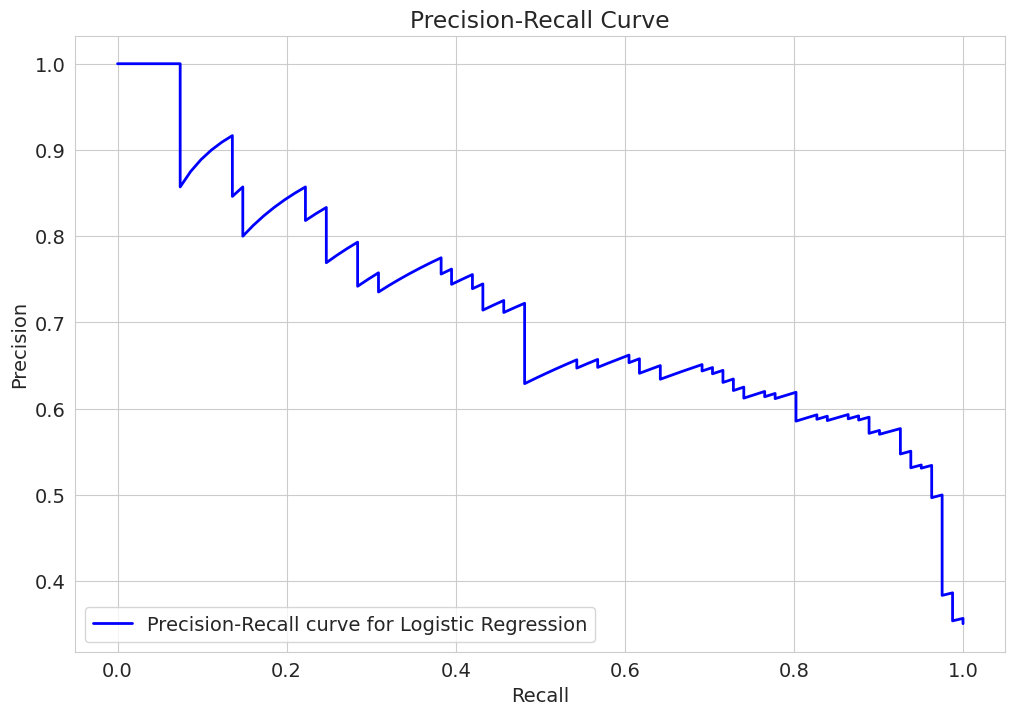

In [25]:
# Precision-Recall curve for the purpose of understanding the tradeoff between precision and recall: 

# y_scores_logreg = best_model_logreg.decision_function(X_test)
# precision, recall, thresholds = precision_recall_curve(y_test, y_scores_logreg)
# area_under_curve = auc(recall, precision)

# plt.figure()
# plt.plot(recall, precision, 'b', lw=2, label='Precision-Recall curve for Logistic Regression')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc="lower left")
# plt.show()




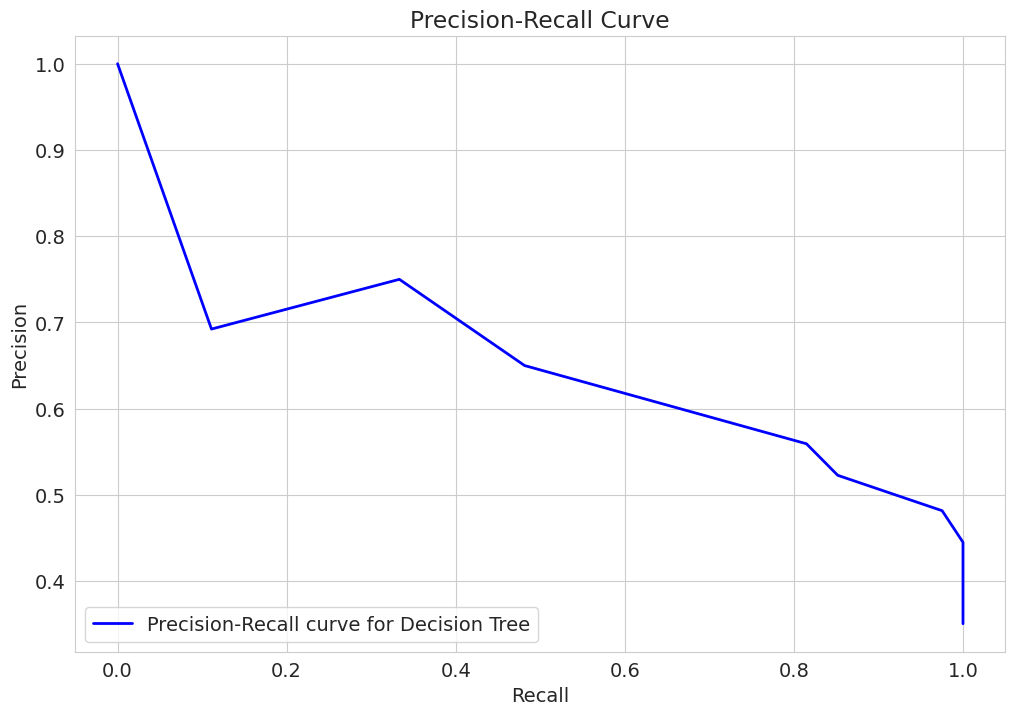

In [26]:
# y_scores_dectree = best_model_decision_tree.predict_proba(X_test)[:,1]
# precision, recall, thresholds = precision_recall_curve(y_test, y_scores_dectree)
# area_under_curve = auc(recall, precision)

# plt.figure()
# plt.plot(recall, precision, 'b', lw=2, label='Precision-Recall curve for Decision Tree')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc="lower left")
# plt.show()

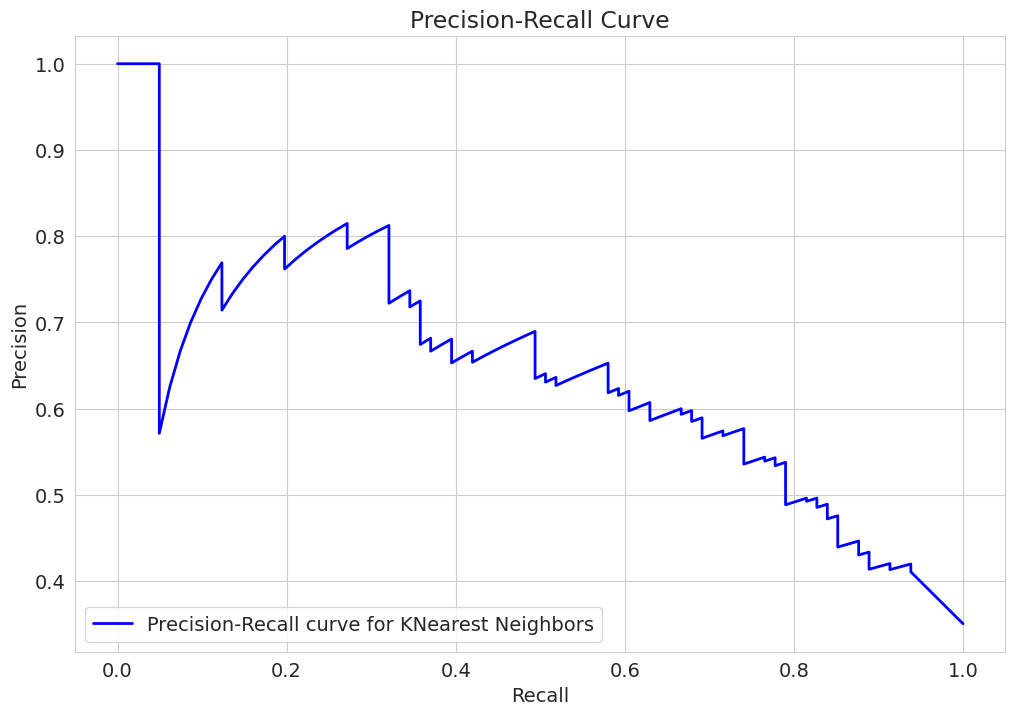

In [27]:
# y_scores_knn = best_model_knn.predict_proba(X_test)[:,1]
# precision, recall, thresholds = precision_recall_curve(y_test, y_scores_knn)
# area_under_curve = auc(recall, precision)

# plt.figure()
# plt.plot(recall, precision, 'b', lw=2, label='Precision-Recall curve for KNearest Neighbors')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc="lower left")
# plt.show()

The most promising keys to improving recall without compromising precision is probably the exploration of different modeling algorithms, instead of further tuning the logistic regression model, and second the tuning of features. 